<div align='left' style="width:400px;height:120px;overflow:hidden;">
<a href='http://www.uff.br'>
<img align='left' style='display: block;height: 92%' src='https://github.com/lmarti/jupyter_custom/raw/master/imgs/uff.png' alt='UFF logo' title='UFF logo'/>
</a>
<a href='http://www.ic.uff.br'>
<img align='left' style='display: block;height: 100%' src='https://github.com/lmarti/jupyter_custom/raw/master/imgs/logo-ic.png' alt='IC logo' title='IC logo'/>
</a>
</div>

# Using genetic algorithms to solve the traveling salesperson problem

## Luis Martí, [IC](http://www.ic.uff.br)/[UFF](http://www.uff.br)

[http://lmarti.com](http://lmarti.com); [lmarti@ic.uff.br](mailto:lmarti@ic.uff.br) 

[Advanced Evolutionary Computation: Theory and Practice](http://lmarti.com/aec-2014) 

The notebook is better viewed rendered as slides. You can convert it to slides and view them by:
- using [nbconvert](http://ipython.org/ipython-doc/1/interactive/nbconvert.html) with a command like:
  ```bash
  $ ipython nbconvert --to slides --post serve <this-notebook-name.ipynb>
  ```
- installing [Reveal.js - Jupyter/IPython Slideshow Extension](https://github.com/damianavila/live_reveal)
- using the online [IPython notebook slide viewer](https://slideviewer.herokuapp.com/) (some slides of the notebook might not be properly rendered).

This and other related IPython notebooks can be found at the course github repository:
* [https://github.com/lmarti/evolutionary-computation-course](https://github.com/lmarti/evolutionary-computation-course)

# [*Traveling Salesperson Problem*](http://en.wikipedia.org/wiki/Traveling_salesman_problem) (TSP): 

> *Given a set of cities, and the distances between each pair of cities, find a **tour** of the cities with the minimum total distance.  A **tour** means you start at one city, visit every other city exactly once, and then return to the starting city.*

- This notebook relies on [Peter Norvig](http://norvig.com/)'s [IPython notebook on the traveling salesperson problem](http://nbviewer.ipython.org/url/norvig.com/ipython/TSPv3.ipynb).
- I will be showing how to apply evolutionary algorithms to solve the TSP.

- This is a well-known [*intractable*](http://en.wikipedia.org/wiki/Intractability_(complexity) problem, meaning that there are no efficient solutions that work for a large number of cities.  
- We can create an inefficient algorithm that works fine for a small number of cites (about a dozen).
- We can also find a *nearly*-shortest tour over thousands of cities. 
- Actually, the fact there is no efficient algorithm is liberating: 
> **This means that we can use a very simple, inefficient algorithm and not feel too bad about it.**

### The *vocabulary* of the problem:

- **City**: For the purpose of this exercise, a city is "atomic" in the sense that we don't have to know anything about the components or attributes of a city, just how far it is from other cities.
- **Cities**: We will need to represent a set of cities; Python's `set` datatype might be appropriate for that.
- **Distance**: We will need the distance between two cities.  If `A` and `B` are cities. This could be done with a function, `distance(A, B)`, or with a dict, `distance[A][B]` or `distance[A, B]`, or with an array if `A` and `B` are integer indexes.  The resulting distance will be a real number (which Python calls a `float`).
- **Tour**: A tour is an ordered list of cities; Python's `list` or `tuple` datatypes would work.
- **Total distance**: The sum of the distances of adjacent cities in the tour.  We will probably have a function, `total_distance(tour)`.

We are doing this demonstration as an IPython notebook. Therefore, we need to perform some initialization.

In [65]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

import random, operator, time, itertools, math
import numpy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

### First algorithm: find the tour with shortest total distance fro all possible tours

> *Generate all the possible tours of the cities, and choose the shortest one (the tour with the minimum total distance).*

We can implement this as the Python function `exact_TSP` (TSP is the standard abbreviation for Traveling Salesperson Problem, and "exact" means that it finds the shortest tour, exactly, not just an approximation to the shortest tour). Here's the design philosophy we will use:

> *Write Python code that closely mirrors the English description of the algorithm.  This will probably require
some auxilliary functions and data structures; just assume we will be able to define them as well, using the same design philosophy.*

In [66]:
def exact_TSP(cities):
    "Generate all possible tours of the cities and choose the shortest one."
    return shortest(alltours(cities))

def shortest(tours): 
    "Return the tour with the minimum total distance."
    return min(tours, key=total_distance)

_Note 1_: We have not yet defined the function `total_distance`, nor `alltours`.
    
_Note 2_: In Python `min(`*collection*`,key=`*function*`)` means to find the element *x* that is a member of *collection* such that *function(x)* is minimized. So `shortest` finds the tour whose `total_distance` in the minimal among the tours. So our Python code implements (and closely mimics) our English description of the algorithm.  Now we need to define what a tour is, and how to measure total distance.

### Representing Tours

- A tour starts in one city, and then visits each of the other cities in order, before finally retirning to the start. 
- A natural representation of the set of available cities is a Python `set`, and a natural representation of a tour is a sequence that is a *permutation* of the set. 
- The tuple `(1, 2, 3)`, for example, represents a tour that starts in city 1, moves to 2, then 3, and then returns to 1 to finish the tour.

In [67]:
alltours = itertools.permutations # The permutation function is already defined in the itertools module
cities = {1, 2, 3}
list(alltours(cities))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

### Representing Cities and Distance


Now for the notion of *distance*.  We define `total_distance(tour)` as the sum of the distances between consecutive cities in the tour; that part is shown below and is easy (with one Python-specific trick: when `i` is 0, then `distance(tour[0], tour[-1])` gives us the wrap-around distance between the first and last cities, because `tour[-1]` is the last element of `tour`). 

In [68]:
def total_distance(tour):
    "The total distance between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

### Distance between cities

Before we can define `distance(A, B)`, the distance between two cities, we have to make a choice. In the fully general version of the TSP problem, the distance between two cities could be anything: it could be the amount of time it takes to travel between cities, the number of dollars it costs, or anything else.

How will we represent a two-dimensional point?  Here are some choices, with their pros and cons:

* **Tuple:** A point (or city) is a two-tuple of (*x*, *y*) coordinates, for example, `(300, 0)`. 
  * **Pro:** Very simple, easy to break a point down into components. Reasonably efficient. 
  * **Con:** doesn't distinguish points from other two-tuples.  If `p` is a point, can't do `p.x` or `p.y`.
            
* **class:** Define `City` as a custom class with *x* and *y* fields. 
  * **Pro:** explicit, gives us `p.x` accessors.
  * **Con:** less efficient because of the overhead of creating user-defined objects.

### Distance between cities (contd)

* **complex:** Python already has the two-dimensional point as a built-in numeric data type, but in a non-obvious way: as *complex numbers*, which inhabit the two-dimensional (real &times; complex) plane. We can make this use more explicit by defining "`City = complex`", meaning that we can construct the representation of a city using the same constructor that makes complex numbers. 
   * **Pro:** most efficient, because it uses a builtin type that is already a pair of numbers. The distance between two points is simple: the absolute value of their difference. 
   * **Con:** it may seem confusing to bring complex numbers into play; can't say `p.x`.
    
* **subclass:** Define "`class Point(complex): pass`", meaning that points are a subclass of complex numbers. 
   * **Pro:** All the pros of using `complex` directly, with the added protection of making it more explicit that these are treated as points, not as complex numbers.
   * **Con:** less efficient than using `complex` directly; still can't do `p.x` or `p.y`.
 
* **subclass with properties:** Define "`class Point(complex): x, y = property(lambda p: p.real), property(lambda p: p.imag)`".
   * **Pro:** All the pros of previous approach, and we can finally say `p.x`.  
   * **Con:** less efficient than using `complex` directly.

From possible alternatives Peter chose to go with `complex` numbers:

In [69]:
City = complex # Constructor for new cities, e.g. City(300, 400)

In [70]:
def distance(A, B): 
    "The Euclidean distance between two cities."
    return abs(A - B)

In [71]:
A = City(300, 0)
B = City(0, 400)
distance(A, B)

500.0

In [72]:
def generate_cities(n):
    "Make a set of n cities, each with random coordinates."
    return set(City(random.randrange(10, 890), 
                    random.randrange(10, 590)) 
               for c in range(n))

In [73]:
cities8, cities10, cities100, cities1000 = generate_cities(8), generate_cities(10), generate_cities(100), generate_cities(1000)
cities8

{(118+330j),
 (27+216j),
 (288+236j),
 (30+110j),
 (332+241j),
 (438+168j),
 (478+578j),
 (594+96j)}

A cool thing is to be able to plot a tour

In [74]:
def plot_tour(tour, alpha=1, color=None):
    # Plot the tour as blue lines between blue circles, and the starting city as a red square.
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], style='gD', alpha=alpha, size=10)
    # plt.show()
    
def plotline(points, style='bo-', alpha=1, size=7, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)
    
    if color:
        plt.plot(X, Y, style, alpha=alpha, markersize=size, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha, markersize=size)
    
def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]

We are ready to test our algorithm

In [75]:
tour = exact_TSP(cities8)

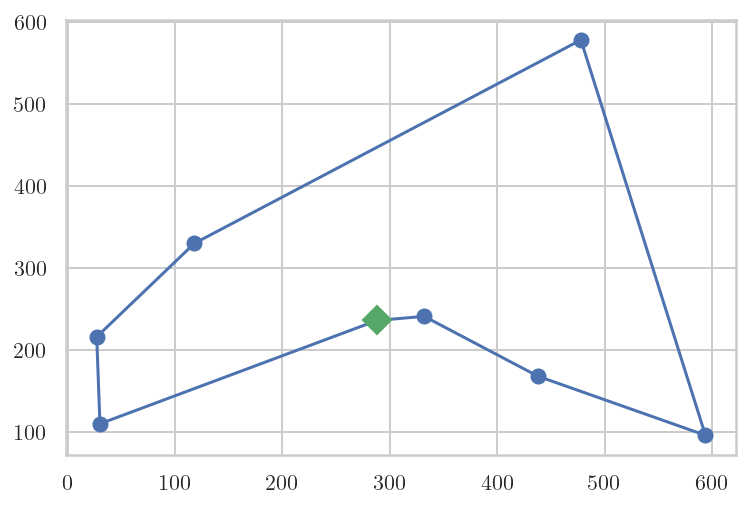

In [76]:
plot_tour(tour)

### Improving the algorithm: Try All Non-Redundant Tours

The permutation `(1, 2, 3)` represents the tour that goes from 1 to 2 to 3 and back to 1.  You may have noticed that there aren't really six different tours of three cities: the cities 1, 2, and 3 form a triangle;  any tour must connect the three points of the triangle; and there are really only two ways to do this: clockwise or counterclockwise.   In general, with $n$ cities, there are $n!$ (that is, $n$ factorial) permutations, but only  $(n-1)!$,  tours that are *distinct*: the tours `123`, `231`, and `312` are three ways of representing the *same* tour.

So we can make our `TSP` program $n$ times faster by never considering redundant tours. Arbitrarily, we will say that all tours must start with the "first" city in the set of cities. We don't have to change the definition of `TSP`&mdash;just by making `alltours` return only nonredundant tours, the whole program gets faster.

(While we're at it, we'll make tours be represented as lists, rather than the tuples that are returned by `permutations`.  It doesn't matter now, but later on we will want to represent *partial* tours, to which we will want to append cities one by one; that can only be done to lists, not tuples.)

In [77]:
def all_non_redundant_tours(cities):
    "Return a list of tours, each a permutation of cities, but each one starting with the same city."
    start = first(cities)
    return [[start] + list(tour)
            for tour in itertools.permutations(cities - {start})]

def first(collection):
    "Start iterating over collection, and return the first element."
    for x in collection: return x

def exact_non_redundant_TSP(cities):
    "Generate all possible tours of the cities and choose the shortest one."
    return shortest(all_non_redundant_tours(cities))

In [78]:
all_non_redundant_tours({1, 2, 3})

[[1, 2, 3], [1, 3, 2]]

### Results of the improvement

In [79]:
%timeit exact_TSP(cities8)

138 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
%timeit exact_non_redundant_TSP(cities8)

17.3 ms ± 671 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [81]:
%timeit exact_non_redundant_TSP(cities10)

1.5 s ± 35.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes a few seconds on my machine to solve this problem. In general, the function `exact_non_redundant_TSP()` looks at $(n-1)!$ tours for an $n$-city problem, and each tour has $n$ cities, so the time for $n$ cities should be roughly proportional to $n!$. This means that the time grows rapidly with the number of cities; we'd need longer than the **[age of the Universe](http://en.wikipedia.org/wiki/Age_of_the_universe)** to run `exact_non_redundant_TSP()` on just 24 cities:

<table>
<tr><th>n cities<th>time
<tr><td>10<td>3 secs
<tr><td>12<td>3 secs &times; 12 &times 11 = 6.6 mins
<tr><td>14<td>6.6 mins &times; 13 &times; 14 = 20 hours
<tr><td>24<td>3 secs &times; 24! / 10! = <a href="https://www.google.com/search?q=3+seconds+*+24!+%2F+10!+in+years">16 billion years</a>
</table>

> There must be a better way... or at least we need to look for it until quantum computing comes around.

# Approximate (Heuristic) Algorithms

- The *general, exact* Traveling Salesperson Problem is intractable; 
- there is no efficient algorithm to find the tour with minimum total distance.  
- But if we restrict ourselves to Euclidean distance and if we are willing to settle for a tour that is *reasonably* short but not the shortest, then the news is much better.  

We will consider several *approximate* algorithms, which find tours that are usually within 10 or 20% of the shortest possible and can handle thousands of cities in a few seconds.

### Greedy Nearest Neighbor (greedy_TSP)

Here is our first approximate algorithm:

> *Start at any city; at each step extend the tour by moving from the previous city to its nearest neighbor that has not yet been visited.*

This is called a *greedy algorithm*, because it greedily takes what looks best in the short term (the nearest neighbor) even when that won't always be the best in the long term. 

To implement the algorithm I need to represent all the noun phrases in the English description: 
   * **start**: a city which is arbitrarily the first city; 
   * **the tour**: a list of cities, initialy just the start city); 
   * **previous city**: the last element of tour, that is, `tour[-1]`);
   * **nearest neighbor**: a function that, when given a city, A, and a list of other cities, finds the one with minimal distance from A); and 
   * **not yet visited**: we will keep a set of unvisited cities; initially all cities but the start city are unvisited).

Once these are initialized, we repeatedly find the nearest unvisited neighbor, `C`, and add it to the tour and remove it from `unvisited`.

In [82]:
def greedy_TSP(cities):
    "At each step, visit the nearest neighbor that is still unvisited."
    start = first(cities)
    tour = [start]
    unvisited = cities - {start}
    while unvisited:
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

In [83]:
def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda x: distance(x, A))

(In Python, as in the formal mathematical theory of computability, `lambda` is the symbol for *function*, so "`lambda x: distance(x, A)`" means the function of `x` that computes the distance from `x` to the city `A`. The name `lambda` comes from the Greek letter &lambda;.)

We can compare the fast approximate `greedy_TSP` algorithm to the slow `exact_TSP` algorithm on a small map, as shown below.  (If you have this page in a IPython notebook you can repeatedly `run` the cell, and see how the algorithms compare. `Cities(9)` will return a different set of cities each time.  I ran it 20 times, and only once did the greedy algorithm find the optimal solution, but half the time it was within 10% of optimal, and it was never more than 25% worse than optimal.)

In [84]:
cities = generate_cities(9)

In [85]:
%timeit exact_non_redundant_TSP(cities)

153 ms ± 4.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


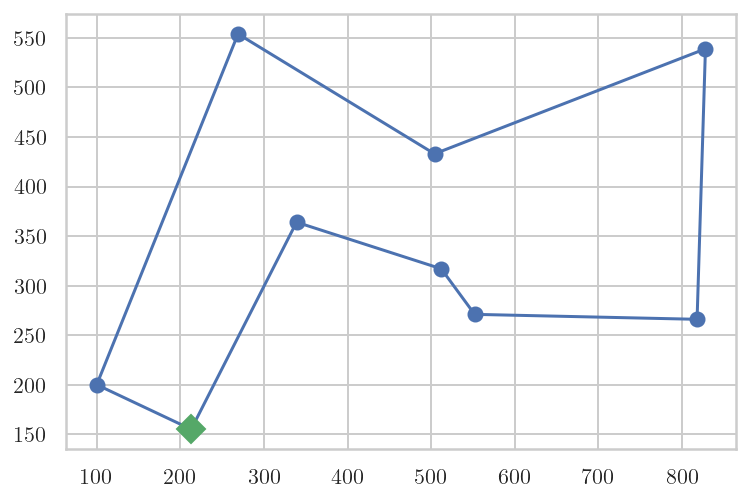

In [86]:
plot_tour(exact_non_redundant_TSP(cities))

In [87]:
%timeit greedy_TSP(cities)

17.7 µs ± 270 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


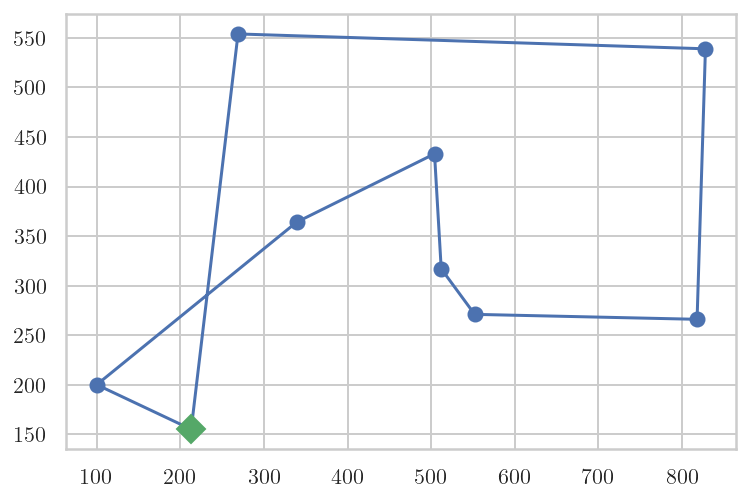

In [88]:
plot_tour(greedy_TSP(cities))

### `greedy_TSP()` can handle bigger problems

In [89]:
%timeit greedy_TSP(cities100)

1.65 ms ± 30.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


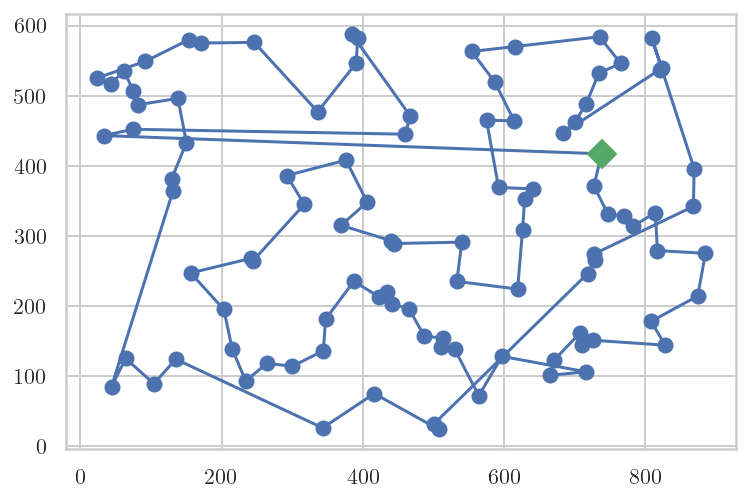

In [90]:
plot_tour(greedy_TSP(cities100))

In [91]:
%timeit greedy_TSP(cities1000)

157 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


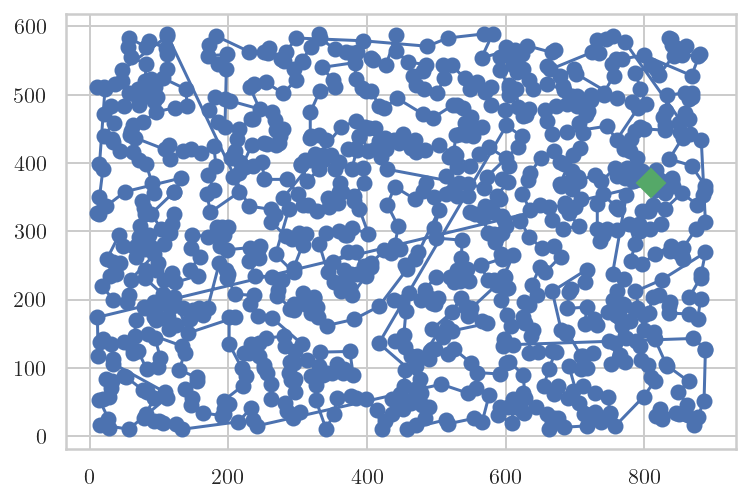

In [92]:
plot_tour(greedy_TSP(cities1000))

### But... don't be greedy!

A [greedy algorithm](http://en.wikipedia.org/wiki/Greedy_algorithm) is an algorithm that follows the problem solving heuristic of making the locally optimal choice at each stage with the hope of finding a global optimum. In many problems, a greedy strategy does not in general produce an optimal solution, but nonetheless a greedy heuristic may yield locally optimal solutions that approximate a global optimal solution in a reasonable time.

For many problmes greedy algorithms fail to produce the optimal solution, and may even produce the *unique worst possible solution*. One example is the traveling salesman problem mentioned above: for each number of cities, there is an assignment of distances between the cities for which the nearest neighbor heuristic produces the unique worst possible tour.

### A thought on computational complexity

<img src='http://imgs.xkcd.com/comics/travelling_salesman_problem.png' align='center' width='65%'/>

[from XKCD](http://xkcd.com/399/)

### Check out [Peter Norvig](http://norvig.com/)'s [IPython notebook on the traveling salesperson problem](http://nbviewer.ipython.org/url/norvig.com/ipython/TSPv3.ipynb) on more alternatives for the TSP.

# Nature-inspired metaheuristics

- We have seen in class some examples of nature-inspired metaheuristics.
- They are an option in which we dedicate a little more computational effort in order to produce better solutions than `greedy_TSP()`.

> We will be using the [DEAP](https://github.com/DEAP/deap) library to code this tackle this problem using a genetic algorithm.

[<img src='https://raw.githubusercontent.com/DEAP/deap/master/doc/_static/deap_long.png' width='29%' align='center'/>](https://github.com/DEAP/deap)

In [93]:
from deap import algorithms, base, creator, tools

### Elements to take into account solving problems with genetic algorithms

* **Individual representation** (binary, floating-point, etc.);
* **evaluation** and **fitness assignment**;
* **selection**, that establishes a partial order of individuals in the population using their fitness function value as reference and determines the degree at which individuals in the population will take part in the generation of new (offspring) individuals.
* **variation**, that applies a range of evolution-inspired operators, like crossover, mutation, etc., to synthesize offspring individuals from the current (parent) population. This process is supposed to prime the fittest individuals so they play a bigger role in the generation of the offspring.
* **stopping criterion**, that determines when the algorithm shoulod be stopped, either because the optimum was reach or because the optimization process is not progressing.

### Hence a 'general' evolutionary algorithm can be described as

```
def evolutionary_algorithm():
    'Pseudocode of an evolutionary algorithm'    
    populations = [] # a list with all the populations
    
    populations[0] =  initialize_population(pop_size)
    t = 0
    
    while not stop_criterion(populations[t]):
        fitnesses = evaluate(populations[t])
        offspring = matting_and_variation(populations[t],
                                          fitnesses)
        populations[t+1] = environmental_selection(           
                                          populations[t],
                                          offspring)
        t = t+1
```

### Some preliminaries for the experiment

We will carry out our tests with a 30-cities problem.

In [94]:
num_cities = 30
cities = generate_cities(num_cities)

The `toolbox` stored the setup of the algorithm. It describes the different elements to take into account.

In [95]:
toolbox = base.Toolbox()

### Individual representation and evaluation
* Individuals represent possible solutions to the problem.
* In the TSP case, it looks like the tour itself can be a suitable representation.
* For simplicity, an individual can be a list with the indexes corresponding to each city.
* This will simplify the crossover and mutation operators.
* We can rely on the `total_distance()` function for evaluation and set the fitness assignment as to minimize it.

In [96]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

D:\anaconda3\envs\deap\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
D:\anaconda3\envs\deap\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Let's now define that our individuals are composed by indexes that referr to elements of `cities` and, correspondingly, the population is composed by individuals.

In [97]:
toolbox.register("indices", numpy.random.permutation, len(cities))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

Defining the crossover and mutation operators can be a challenging task.

There are  various <a href='http://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)#Crossover_for_Ordered_Chromosomes'>crossover operators</a> that have been devised to deal with ordered individuals like ours.

- We will be using DEAP's `deap.tools.cxOrdered()` crossover.
- For mutation we will swap elements from two points of the individual.
- This is performed by `deap.tools.mutShuffleIndexes()`.

In [98]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)


Evaluation can be easily defined from the `total_distance()` definition.


In [99]:
def create_tour(individual):
    return [list(cities)[e] for e in individual]

In [100]:
def evaluation(individual):
    '''Evaluates an individual by converting it into 
    a list of cities and passing that list to total_distance'''
    return (total_distance(create_tour(individual)),)

In [101]:
toolbox.register("evaluate", evaluation)

We will employ tournament selection with size 3.

In [102]:
toolbox.register("select", tools.selTournament, tournsize=3)

Lets' run the algorithm with a population of 100 individuals and 400 generations.

In [103]:
pop = toolbox.population(n=100)

In [104]:
%%time 
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=400, verbose=False)

Wall time: 4.92 s


### We can now review the results

The best individual of the last population:

In [105]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  3594.438762096406


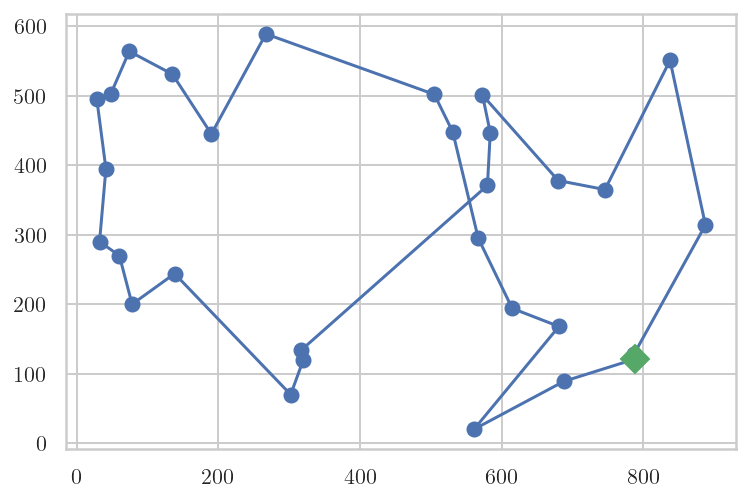

In [106]:
plot_tour(create_tour(best_individual))

It is interesting to assess how the fitness of the population changed as the evolution process took place. 

We can prepare an `deap.tools.Statistics` instance to specify what data to collect. 

In [107]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', numpy.mean)
fit_stats.register('min', numpy.min)

We are all set now but lets run again the genetic algorithm configured to collect the statistics that we want to gather:

In [108]:
result, log = algorithms.eaSimple(toolbox.population(n=100), toolbox,
                                  cxpb=0.5, mutpb=0.2,
                                  ngen=400, verbose=False,
                                  stats=fit_stats)

### Plotting mean and minimium fitness as evolution took place.

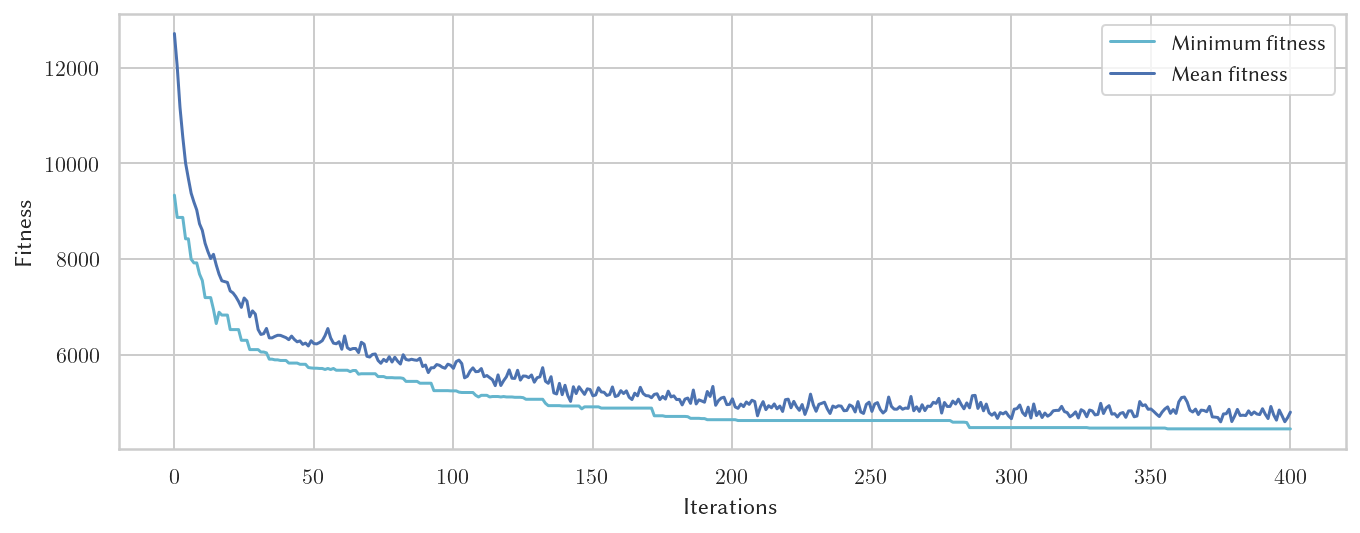

In [109]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');

### How has the population evolved?

Ok, but how the population evolved? As TSP solutions are easy to visualize, we can plot the individuals of each population the evolution progressed. We need a new `Statistics` instance prepared for that.

In [110]:
pop_stats = tools.Statistics(key=numpy.copy)
pop_stats.register('pop', numpy.copy) # -- copies the populations themselves
pop_stats.register('fitness', # -- computes and stores the fitnesses
                   lambda x : [evaluation(a) for a in x]) 

_Note_: I am aware that this could be done in a more efficient way.

In [111]:
result, log = algorithms.eaSimple(toolbox.population(n=100), toolbox,
                                  cxpb=0.5, mutpb=0.2,
                                  ngen=400, verbose=False,
                                  stats=pop_stats)

### Plotting the individuals and their fitness (color-coded)

In [112]:
def plot_population(record, min_fitness, max_fitness):
    '''
    Plots all individuals in a population. 
    Darker individuals have a better fitness.
    '''
    pop = record['pop']
    fits = record['fitness']
    index = sorted(range(len(fits)), key=lambda k: fits[k])

    norm=colors.Normalize(vmin=min_fitness,
                          vmax=max_fitness)
    sm = cmx.ScalarMappable(norm=norm, 
                            cmap=plt.get_cmap('PuBu'))
    
    for i in range(len(index)):
        color = sm.to_rgba(max_fitness - fits[index[i]][0])
        plot_tour(create_tour(pop[index[i]]), alpha=0.5, color=color)

In [113]:
min_fitness = numpy.min(log.select('fitness'))
max_fitness = numpy.max(log.select('fitness'))

We can now plot the population as the evolutionary process progressed. Darker blue colors imply better fitness.

C:\Users\janey\AppData\Local\Temp/ipykernel_10308/3657239361.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X, Y, style, alpha=alpha, markersize=size, color=color)


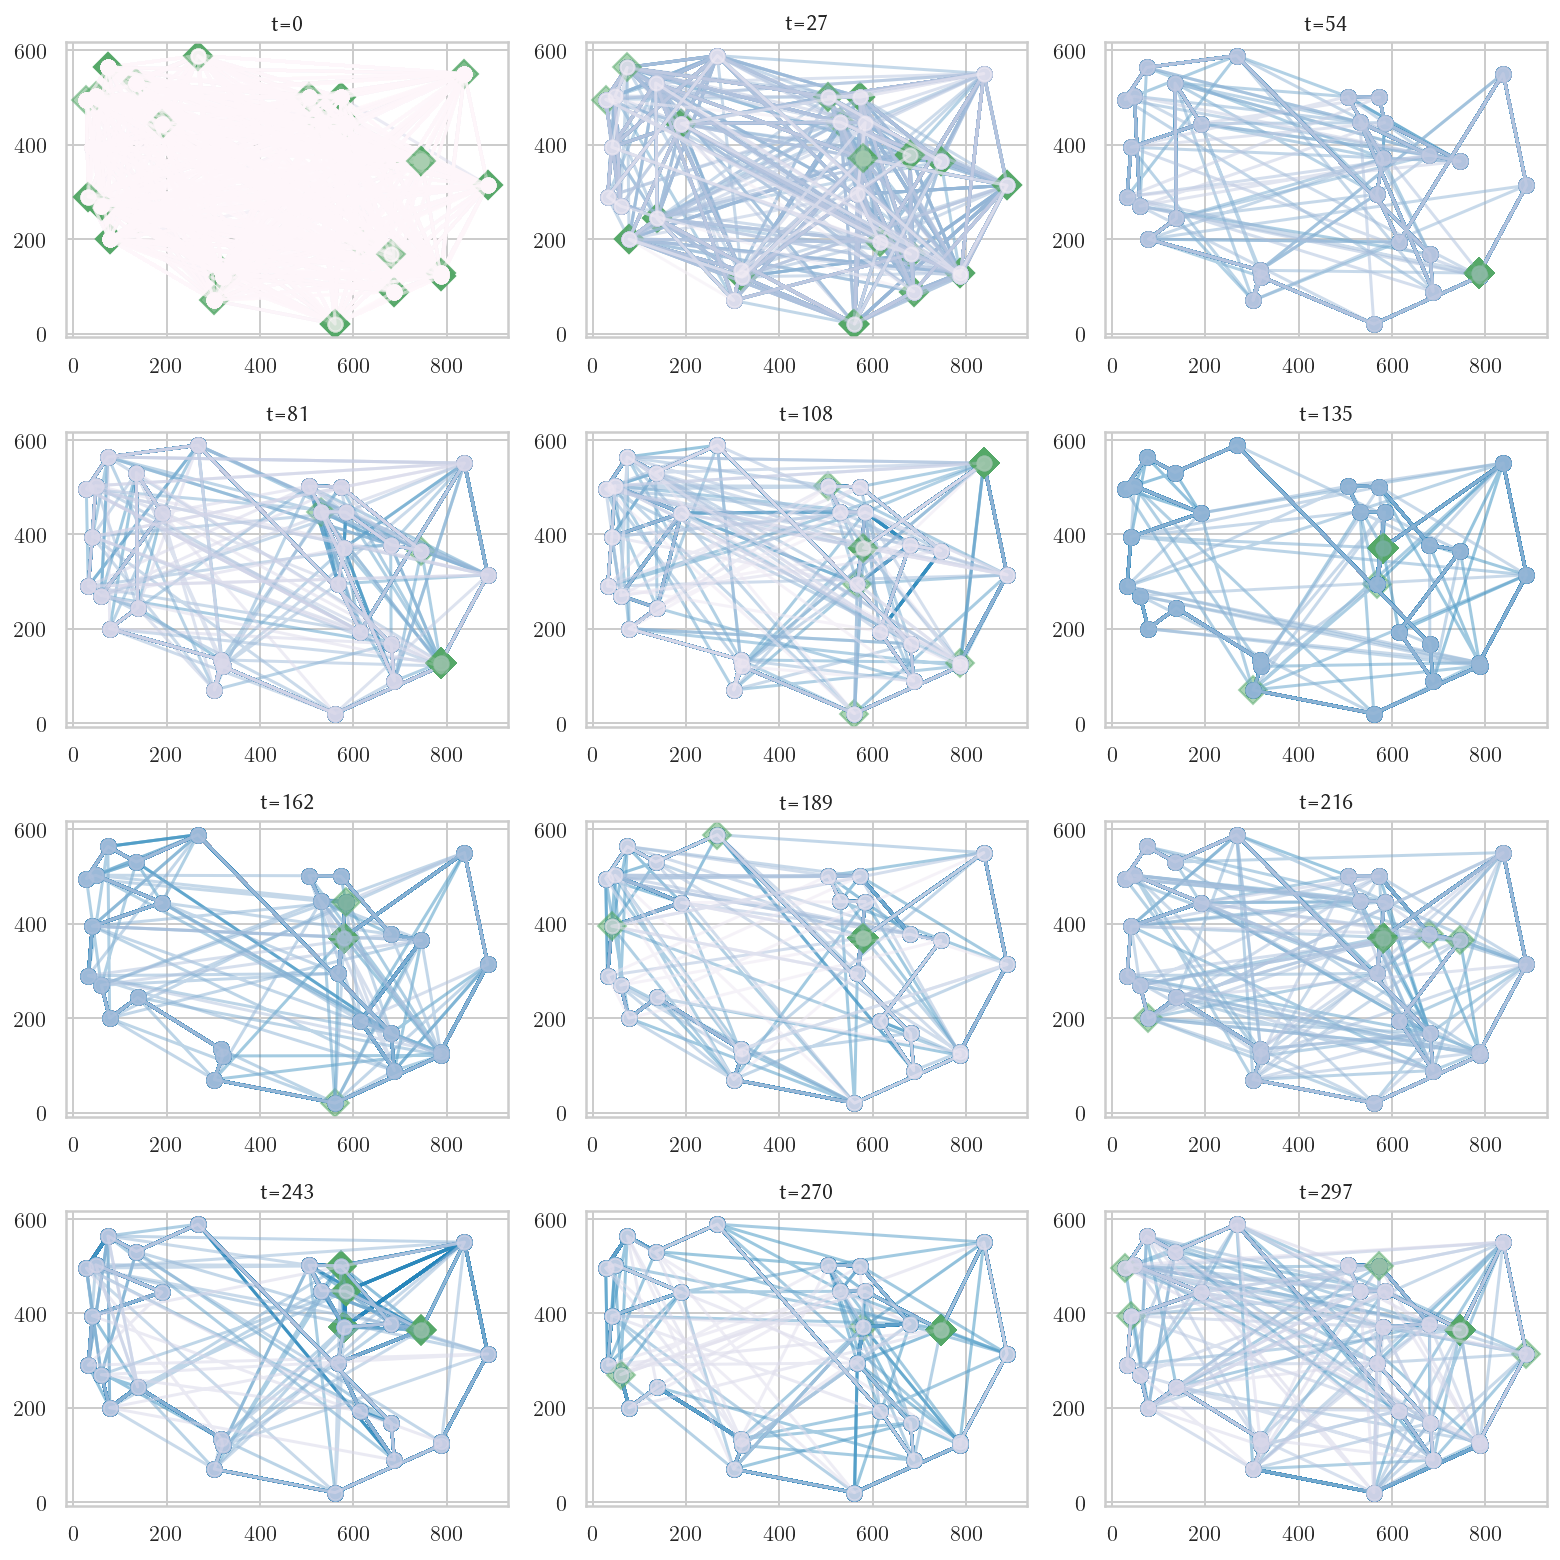

In [114]:
plt.figure(figsize=(11,11))
for i in range(0, 12):
    plt.subplot(4,3,i+1)
    it = int(math.ceil((len(log)-1.)/15))
    plt.title('t=' + str(it*i))
    plot_population(log[it*i], min_fitness, max_fitness)
plt.tight_layout()

The population of the previous experiment can be better appreciated in animated form.

In [115]:
from matplotlib import animation
from IPython.display import HTML

In [116]:
def update_plot_tour(plot, points, alpha=1, color='blue'):
    'A function for updating a plot with an individual'
    X, Y = XY(list(points) + [points[0]])
    plot.set_data(X, Y)
    plot.set_color(color)
    return plot

In [117]:
def init():
    'Initialization of all plots to empty data'
    for p in list(tour_plots):
        p.set_data([], [])
    return tour_plots

In [118]:
def animate(i):
    'Updates all plots to match frame _i_ of the animation' 
    pop = log[i]['pop']
    fits = log[i]['fitness']
    index = sorted(range(len(fits)), key=lambda k: fits[k])

    norm=colors.Normalize(vmin=min_fitness,
                          vmax=max_fitness)
    sm = cmx.ScalarMappable(norm=norm, 
                            cmap=plt.get_cmap('PuBu'))
    for j in range(len(tour_plots)):
        color = sm.to_rgba(max_fitness - fits[index[j]][0])
        update_plot_tour(tour_plots[j], 
                         create_tour(pop[index[j]]), 
                         alpha=0.5, color=color)
    return tour_plots

The next step takes some time to execute. Use the video controls to see the evolution in animated form.

In [121]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 900), ylim=(0, 600))
tour_plots = [ax.plot([], [], 'bo-', alpha=0.1) for i in range(len(log[0]['pop']))]
tour_plots = [p[0] for p in tour_plots]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=60, blit=True)
plt.close()

In [123]:
HTML(anim.to_html5_video())

### Comprarison with `greedy_TSP()`

In [124]:
%timeit total_distance(greedy_TSP(cities))

164 µs ± 2.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [125]:
print('greedy_TSP() distance: ', total_distance(greedy_TSP(cities)))
print('Genetic algorithm best distance: ', evaluation(best_individual)[0])

greedy_TSP() distance:  4013.25273893973
Genetic algorithm best distance:  3594.438762096406


The genetic algorithm outperformed the greedy approach at a *viable* computational cost.

- _Note 1_: *Viable* depends on the particular problem, of course.
- _Note 2_: These results depend on the cities that were randomly generated. Your milleage may vary.

Homework
--------

1. We have just performed one run of the experiment, but genetic algorithms are stochastic algorithms and their performace should be assessed in statistical terms. Modify the genetic algorithm code in order to be able to report the comparison with `greedy_TSP()` in statistically sound terms.
2. Population size should have an impact on the performace of the algorithm. Make an experiment regarding that.
3. What is the influence of the mutation and crossover probabilities in the performance of the genetic algorithm?

<hr/>
<div class="container-fluid">
  <div class='well'>
      <div class="row">
          <div class="col-md-3" align='center'>
              <img align='center'alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png"/>
          </div>
          <div class="col-md-9">
              This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).
          </div>
      </div>
  </div>
</div>

In [126]:
# To install run: pip install version_information
%load_ext version_information
%version_information scipy, numpy, matplotlib, seaborn, deap

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.9.7 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.31.1
OS Windows 10 10.0.19044 SP0
scipy 1.7.3
numpy 1.22.1
matplotlib 3.5.1
seaborn 0.11.2
deap 1.3
Sat Feb 12 00:21:25 2022 中国标准时间

In [128]:
# this code is here for cosmetic reasons
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))